# P3 Concevez une application au service de la santé publique 

L'agence <span style='color:blue'> <a href = "http://www.santepubliquefrance.fr/">"*Santé publique France*" </a></span> a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. <br>
Vous souhaitez y participer et proposer une idée d’application.

Le jeu de données <font color='orange'>Open Food Facts</font> est disponible sur le <a href = "https://world.openfoodfacts.org/">site officiel</a> (ou disponible à <a href ="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip">ce lien</a> en téléchargement).
<br>
Les variables sont définies à <a href = "https://world.openfoodfacts.org/data/data-fields.txt">cette adresse</a>

Les champs sont séparés en quatre sections :

- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
%%time
df_openfoodfacts = pd.read_csv("df_openfoodfacts.csv",sep='\t',low_memory=False).drop(['quantity','serving_size'],axis=1)
df_openfoodfacts.additives_n = [float(x) for x in df_openfoodfacts.additives_n]

CPU times: total: 5.48 s
Wall time: 5.49 s


In [4]:
nbLigne, nbCol = df_openfoodfacts.shape
nbLigne, nbCol

mask = df_openfoodfacts.dtypes.value_counts().reset_index()
mask.rename(columns={'index':'type',0:'Nb'},inplace=True)
nbColInt = mask.Nb[mask.type=='int64']
nbColObject = mask.Nb[mask.type=='object']
nbColFloat64 = mask.Nb[mask.type=='float64']
#nbColDate = mask.Nb[mask.type=='Date']#'object''float64'

In [5]:
print('Le fichier comtient {} variables numeriques et {} varriables catégoriques et {} lignes.'\
      .format(nbColInt.values[0]+nbColFloat64.values[0],nbColObject.values[0],nbLigne ) )

Le fichier comtient 92 variables numeriques et 6 varriables catégoriques et 320749 lignes.


In [6]:
df_openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320749 entries, 0 to 320748
Data columns (total 98 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     320749 non-null  object 
 1   product_name                             302987 non-null  object 
 2   categories_fr                            84389 non-null   object 
 3   ingredients_text                         248939 non-null  object 
 4   additives_n                              248939 non-null  float64
 5   main_category_fr                         84366 non-null   object 
 6   ingredients_from_palm_oil_n              248939 non-null  float64
 7   ingredients_that_may_be_from_palm_oil_n  248939 non-null  float64
 8   nutrition_grade_fr                       221210 non-null  object 
 9   nutrition-score-fr_100g                  221210 non-null  float64
 10  presenceDeLabels                

In [7]:
# étende la largeur d'affichage de la colonne pandas df pour permettre une inspection facile
pd.set_option('max_colwidth', 150)
df_openfoodfacts.head()

,code,product_name,categories_fr,ingredients_text,additives_n,main_category_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,nutrition-score-fr_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,bocal/conserve,creme/sauce,litre,petit pot/yaourt,poids,unité
0,0000000003087,Farine de blé noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
1,0000000004530,Banana Chips Sweetened (Whole),NaN,"Bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor.",0.0,NaN,0.0,0.0,d,14.0,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
2,0000000004559,Peanuts,NaN,"Peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening (ammonium bicarbonate, baking soda), soy sauce (water, soybeans, wheat, s...",0.0,NaN,0.0,0.0,b,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
3,0000000016087,Organic Salted Nut Mix,NaN,"Organic hazelnuts, organic cashews, organic walnuts almonds, organic sunflower oil, sea salt.",0.0,NaN,0.0,0.0,d,12.0,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
4,0000000016094,Organic Polenta,NaN,Organic polenta,0.0,NaN,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0


In [8]:
df_openfoodfacts.dtypes.value_counts()

float64    85
int64       7
object      6
dtype: int64

In [9]:
pd.options.display.max_rows=100
df_openfoodfacts\
.drop(columns=['code','product_name','categories_fr','ingredients_text','nutrition_grade_fr','main_category_fr'])\
.isna()\
.sum()/nbLigne

additives_n                                0.223882
ingredients_from_palm_oil_n                0.223882
ingredients_that_may_be_from_palm_oil_n    0.223882
nutrition-score-fr_100g                    0.310333
presenceDeLabels                           0.000000
energy_100g                                0.000000
energy-from-fat_100g                       0.000000
fat_100g                                   0.000000
saturated-fat_100g                         0.000000
caprylic-acid_100g                         0.000000
capric-acid_100g                           0.000000
lauric-acid_100g                           0.000000
myristic-acid_100g                         0.000000
palmitic-acid_100g                         0.000000
stearic-acid_100g                          0.000000
arachidic-acid_100g                        0.000000
montanic-acid_100g                         0.000000
monounsaturated-fat_100g                   0.000000
polyunsaturated-fat_100g                   0.000000
omega-3-fat_

### Analyse en Composante Principale

In [10]:
from sklearn import preprocessing as prep

X = df_openfoodfacts\
.drop(columns=['code','product_name','categories_fr','ingredients_text','nutrition_grade_fr','main_category_fr'])\
.dropna()

std_scale = prep.StandardScaler()
X_scaled = std_scale.fit_transform(X)

#### Calcul des composantes principales

In [11]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

#### Pourcentage de variance expliquée

In [12]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.04821264 0.03347315]
0.08168579429501252


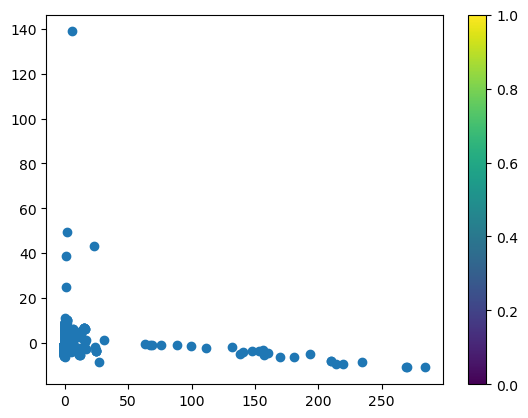

In [17]:
import matplotlib.pyplot as plt


# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable 'Rank'
    #c=df.Rank
           )

#plt.xlim([-5.5, 5.5])
#plt.ylim([-4, 4])
plt.colorbar()

#### Contribution de chaque variable aux composantes principales

(-0.7, 0.7)

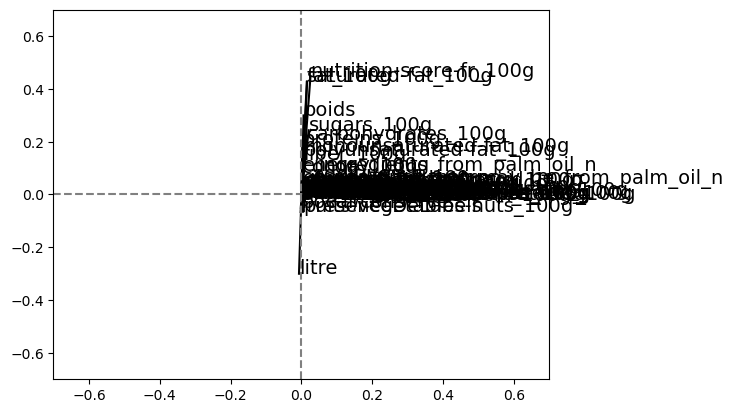

In [16]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

#### Calcul des composantes principales

### Machine Learning

#### Création matrix de données 

In [ ]:
X = dataset.iloc[:, :-1].values #.values permet d'obtenir un objet
y = dataset.iloc[:, 3].values

#### Echantillonnage

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,  y, 
                                                    test_size = 0.2, # 20% du jeux de données réservé pour test la qualité du model
                                                    random_state = 0)

#### Valeurs manquantes

In [ ]:
# Taking care of missing data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X_train[:, 1:3])
X_train[:, 1:3] = imputer.transform(X_train[:, 1:3])


#### Encodage données categorique

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encoding the Independent Variable
labelencoder_X = LabelEncoder()
X_train[:, 0] = labelencoder_X.fit_transform(X_train[:, 0])

onehotencoder = OneHotEncoder(categorical_features = [0])
X_train = onehotencoder.fit_transform(X_train).toarray()

# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
y_train = labelencoder_y.fit_transform(y_train)

#### Centrage réduction

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)

## Regression lineaire

In [ ]:
from sklearn import linear_model
reglin = linear_model.LinearRegression(fit_intercept = False #car les données sont centrés et réduit z = (x - u) / s
                                      )

In [ ]:
# entrainement du model
reglin.fit(X_train,y_train) 

In [ ]:
#Le coefficient de determination de la prediction
reg.score(X_test, y_test)

## KNN

In [ ]:
### KNN
from sklearn import neighbors

#### fine tuning

In [ ]:
kmintest = 2
kmaxtotest = 15
errors = []
for k in range(kmintest,kmaxtotest):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    
    # cross validation
    errors.append(100 * (1-knn.fit(X_train,Y_train).score(X_val,Y_val)
                         
plt.plot(range(kmintest,kmaxtotest),errors, 'o-'))
plt.show()

#### meilleur modele

In [ ]:
modelKNN = neighbors.KNeighborsClassifier(n_neighbors=k_best).fit(X_train,Y_train)

#### performance modele

In [ ]:
modelKNN.score(X_test, y_test)

In [ ]:
error = round((1 - modelKNN.score(xtest, ytest)) *100,ndigits=2)
print('Erreur: %f' % error)

In [1]:
wait

NameError: name 'wait' is not defined